In [1]:
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
import math
import time
import Apparatus as ap
import Algorithms as alg
import time
import pybm3d.bm3d
import scipy.misc as misc
%load_ext autoreload
%autoreload 1
%aimport Apparatus
%aimport Algorithms
%matplotlib inline
np.random.seed(1) # Reproducibility 

## Regularizer Preliminary Tests

In [2]:
def reg1(y, std): # Only Real part
    x = y.copy()
    x.shape = (x.shape[0], x.shape[1],1) ## Need 3D
    x = np.asarray(pybm3d.bm3d.bm3d(x.astype(np.float32),std)) ## Convert back to array from Cython memoryview
    return x.reshape(x.shape[0], x.shape[1])

In [3]:
def reg2(y, std): # Absolute value
    x = np.abs(y).copy()
    x.shape = (x.shape[0], x.shape[1],1) ## Need 3D
    x = np.asarray(pybm3d.bm3d.bm3d(x.astype(np.float32),std)) ## Convert back to array from Cython memoryview
    return x.reshape(x.shape[0], x.shape[1])

In [4]:
def reg3(y, std): # Real and Imaginary separate 
    x = y.copy()
    x.shape = (x.shape[0], x.shape[1],1) ## Need 3D
    imag = np.imag(x).astype(np.float32)
    real = np.real(x).astype(np.float32)
    x = np.asarray(pybm3d.bm3d.bm3d(real,std)) + 1j * np.asarray(pybm3d.bm3d.bm3d(imag,std))  ## Convert back to array from Cython memoryview
    return x.reshape(x.shape[0], x.shape[1])

In [5]:
def reg4(y, std): # Phase and Magnitude separate 
    x = y.copy()
    x.shape = (x.shape[0], x.shape[1],1) ## Need 3D
    mag = pybm3d.bm3d.bm3d(np.abs(x).astype(np.float32),std) # 
#     phase = pybm3d.bm3d.bm3d(np.angle(x).astype(np.float32),10*std) #
    phase = np.angle(x).astype(np.float32)
    x = np.asarray(mag) * (np.cos(np.asarray(phase)) + 1j * np.sin(np.asarray(phase))) # z = r(cos(phi) + i*sin(phi))
    return x.reshape(x.shape[0], x.shape[1])

In [6]:
# image & mask 
data = np.load('images/brain.npz')
im, mask_unif, mask_vardens, pdf_unif, pdf_vardens = \
data['im'], data['mask_unif'], data['mask_vardens'], data['pdf_unif'], data['pdf_vardens']

Naive error:  72.3612470776


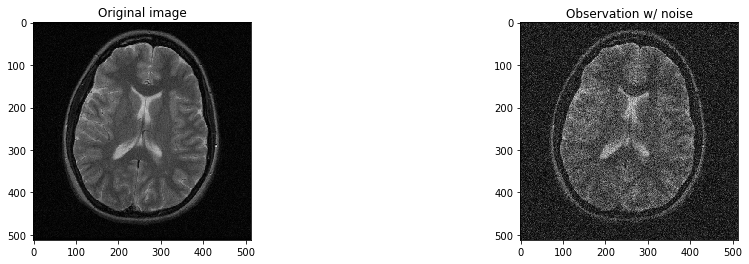

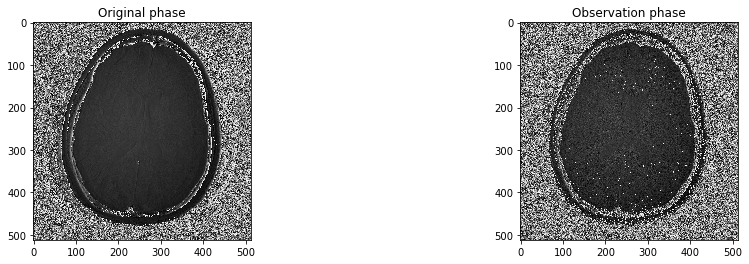

In [9]:
TESTER = im.copy()
TESTER = TESTER + 0.1 * np.random.randn(TESTER.shape[0],TESTER.shape[1]) \
                + 1j*0.1 * np.random.randn(TESTER.shape[0],TESTER.shape[1])
test1 = TESTER.copy()
test2 = TESTER.copy()
test3 = TESTER.copy()
test4 = TESTER.copy()

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
ap.imshowgray(np.abs(im))
plt.title("Original image")
plt.subplot(1,2,2)
ap.imshowgray(np.abs(TESTER))
plt.title("Observation w/ noise")
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
ap.imshowgray(np.angle(im))
plt.title("Original phase")
plt.subplot(1,2,2)
ap.imshowgray(np.angle(TESTER))
plt.title("Observation phase")
print("Naive error: ", np.linalg.norm(im - TESTER))

In [11]:
length = 6 ## Set necessary level of depth
lamb = [10**(-i) for i in range(length)] 
lamb

[1, 0.1, 0.01, 0.001, 0.0001, 1e-05]

In [20]:
# bm3dtest1 = np.zeros((length,512,512))
# bm3dtest2 = np.zeros((length,512,512))
bm3dtest3 = np.zeros((length,512,512))
bm3dtest4 = np.zeros((length,512,512))

for i in range(length):
    bm3dtest1[i] = reg1(test1, lamb[i])
    bm3dtest2[i] = reg2(test2, lamb[i])
    bm3dtest3[i] = reg3(test3, lamb[i])
    bm3dtest4[i] = reg4(test4, lamb[i])

/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.
/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


#### Different values for noise std amd comparison of the regularizers  - Magnitude

only real: 


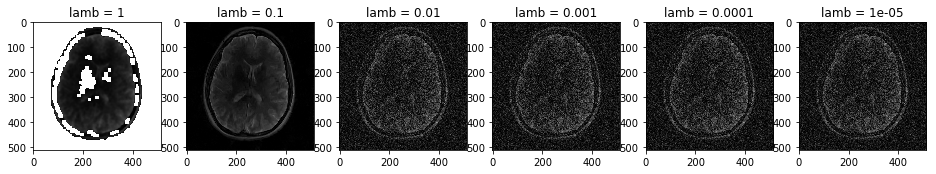

absolute: 


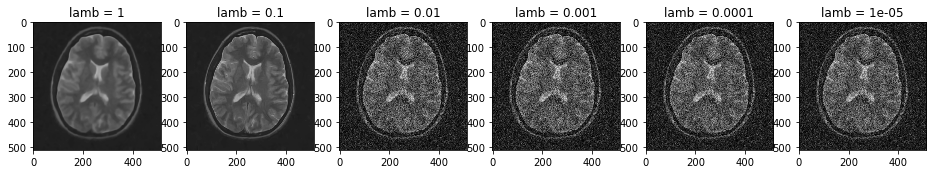

real & imag: 


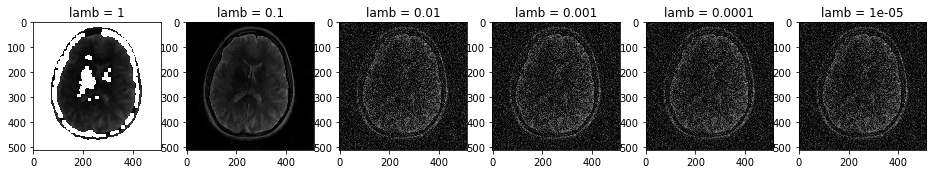

mag and phase: 


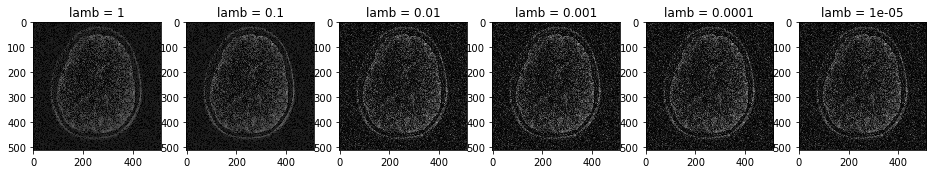

In [18]:
plt.figure(figsize=(16,4))
print("only real: ")
for i in range(length):
    plt.subplot(1,length,i+1)
    plt.title("lamb = {}".format(lamb[i]))
    ap.imshowgray(np.abs(bm3dtest1[i]),0,1)
plt.show()
print("absolute: ")
plt.figure(figsize=(16,4))
for i in range(length):
    plt.subplot(1,length,i+1)
    plt.title("lamb = {}".format(lamb[i]))
    ap.imshowgray(np.abs(bm3dtest2[i]),0,1)
plt.show()
print("real & imag: ")
plt.figure(figsize=(16,4))
for i in range(length):
    plt.subplot(1,length,i+1)
    plt.title("lamb = {}".format(lamb[i]))
    ap.imshowgray(np.abs(bm3dtest3[i]),0,1)
plt.show()
print("mag and phase: ")
plt.figure(figsize=(16,4))
for i in range(length):
    plt.subplot(1,length,i+1)
    plt.title("lamb = {}".format(lamb[i]))
    ap.imshowgray(np.abs(bm3dtest4[i]),0,1)


#### Different values for noise std amd comparison of the regularizers  - Phase

only real: 


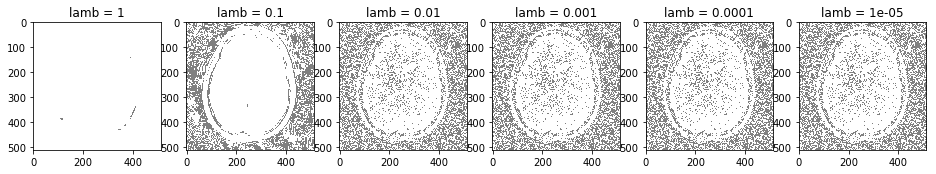

absolute: 


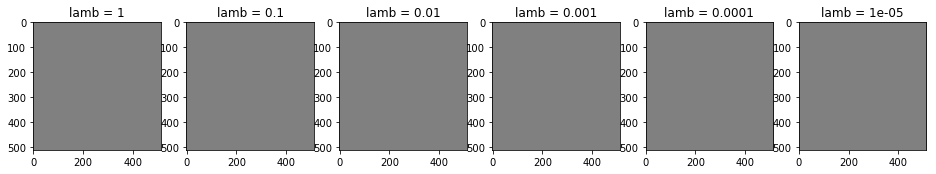

real & imag: 


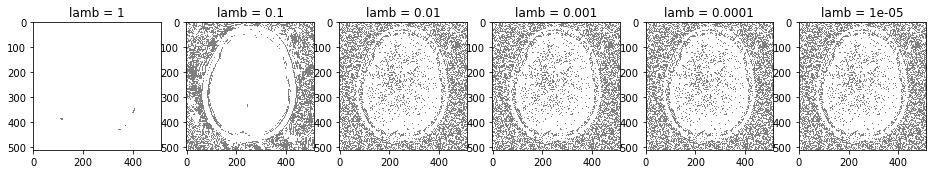

mag and phase: 


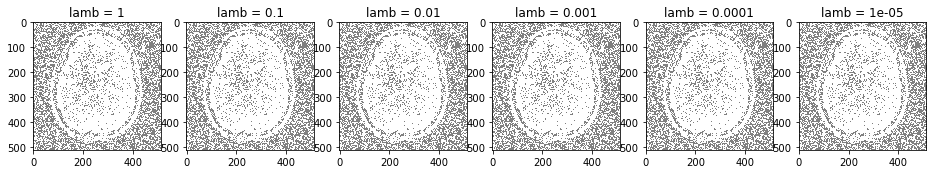

In [19]:
plt.figure(figsize=(16,4))
print("only real: ")
for i in range(length):
    plt.subplot(1,length,i+1)
    plt.title("lamb = {}".format(lamb[i]))
    ap.imshowgray(np.angle(bm3dtest1[i]),-np.pi,np.pi)
plt.show()
print("absolute: ")
plt.figure(figsize=(16,4))
for i in range(length):
    plt.subplot(1,length,i+1)
    plt.title("lamb = {}".format(lamb[i]))
    ap.imshowgray(np.angle(bm3dtest2[i]),-np.pi,np.pi)
plt.show()
print("real & imag: ")
plt.figure(figsize=(16,4))
for i in range(length):
    plt.subplot(1,length,i+1)
    plt.title("lamb = {}".format(lamb[i]))
    ap.imshowgray(np.angle(bm3dtest3[i]),-np.pi,np.pi)
plt.show()
print("mag and phase: ")
plt.figure(figsize=(16,4))
for i in range(length):
    plt.subplot(1,length,i+1)
    plt.title("lamb = {}".format(lamb[i]))
    ap.imshowgray(np.angle(bm3dtest4[i]),-np.pi,np.pi)


#### Phase regularized inappropriately ### FIX!

## Regularizer (BM3D) Tests

In [21]:
def reg(y, std):
    x = y.copy()
    x.shape = (x.shape[0], x.shape[1],1) ## Need 3D
    imag = np.imag(x).astype(np.float32)
    real = np.real(x).astype(np.float32)
    x = np.asarray(pybm3d.bm3d.bm3d(real,std)) + 1j * np.asarray(pybm3d.bm3d.bm3d(imag,std))  ## Convert back to array from Cython memoryview
    return x.reshape(x.shape[0], x.shape[1])

## Problem Setup

Näive-True Signal Error:  11.1202986937


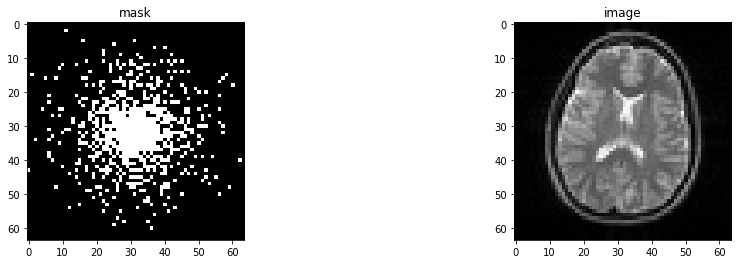

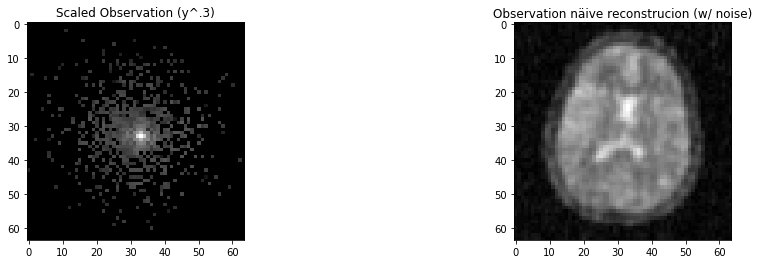

In [22]:
# image and mask resize
mid = len(im[0]) // 2 - 1
fft = ap.fft2c(im)
crop = fft[mid - 32:mid + 32:, mid - 32:mid + 32:]
myImg = ap.ifft2c(crop)
pdf = misc.imresize(pdf_vardens, (64,64))
pdf = pdf / np.max(pdf.ravel())
mask = ((np.random.rand(pdf.shape[0], pdf.shape[1]) < 1.2 * pdf)).astype(int)


# mask
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title("mask")
ap.imshowgray(mask)

# image
plt.subplot(1,2,2)
plt.title("image")
ap.imshowgray(np.abs(myImg))

# parameters
gamma = 0.0001 # Noise STD in BM3D's case 
dim = 2
N = 64


# initiate objects 
operatorObject = ap.Operator(ap.fft2c,ap.ifft2c,mask)   

# signal 
x = myImg.copy()
# plt.figure(figsize=(16,4))
# plt.subplot(1,2,1)
# plt.title('(fully sampled) K-Space')
# ap.imshowgray(np.abs(ap.fft2c(myImg)))

# forward oprator ( + added noise)
y = myImg.copy() + 0.01 * np.random.randn(myImg.shape[0],myImg.shape[1]) + 1j* 0.01 * np.random.randn(myImg.shape[0],myImg.shape[1]) ## NOISE
y = operatorObject.A(y)
# plt.subplot(1,2,2)
# plt.title('Observation')
# ap.imshowgray(np.abs(y))

# Scaled Observation 
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title('Scaled Observation (y^.3)')
ap.imshowgray(np.abs(y**.3))

# Observation näive reconstrucion (ifft)
plt.subplot(1,2,2)
plt.title('Observation näive reconstrucion (w/ noise)')
naive = ap.ifft2c(y)
ap.imshowgray(np.abs(naive))

# Passed Arguments 
params = {}
params['A'] = operatorObject.A
params['AT'] = operatorObject.AT
params['ATA'] = operatorObject.ATA
params['y'] = y
params['Reg'] = reg
params['lamb'] = gamma
params['dim'] = dim
params['signal'] = x
params['N'] = N
# params['n'] = n
# params['signalObject'] = signalObject

print("Näive-True Signal Error: ", np.linalg.norm(naive - x,2))

## ISTA

Iteration:  100
True Signal Error:  11.120317681
Objective Function Error:  0.0161795199446
Time:  29.482496976852417


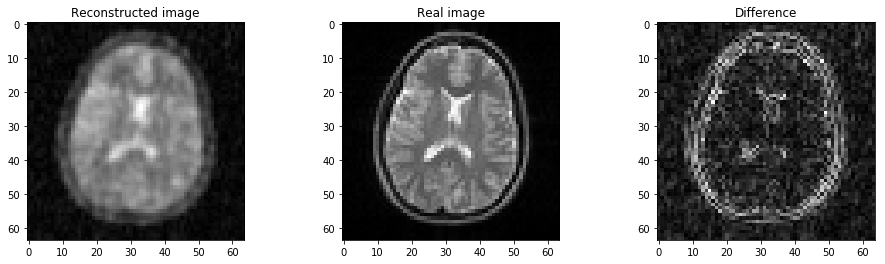

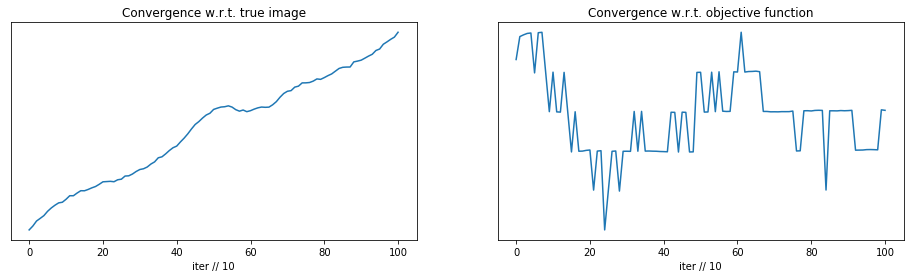

In [23]:
params['niter'] = 100
start = time.time()
ista = alg.ISTA(params)
end = time.time()
x_ista = ista.result
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title("Reconstructed image")
ap.imshowgray(np.abs(x_ista))
plt.subplot(1,3,2)
plt.title("Real image")
ap.imshowgray(np.abs(x))
plt.subplot(1,3,3)
plt.title("Difference")
ap.imshowgray(np.abs(x - x_ista))
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title("Convergence w.r.t. true image")
plt.xlabel("iter // 10")
plt.semilogy(ista.conv)
plt.subplot(1,2,2)
plt.title("Convergence w.r.t. objective function")
plt.xlabel("iter // 10")
plt.semilogy(ista.objective)
print("Iteration: ", ista.counter)
print("True Signal Error: ", ista.conv[-1])
print("Objective Function Error: ", ista.objective[-1])
print("Time: ", end-start)

## FISTA

Iteration:  100
True Signal Error:  11.1204939991
Objective Function Error:  0.0161792176493
Time:  29.47814702987671


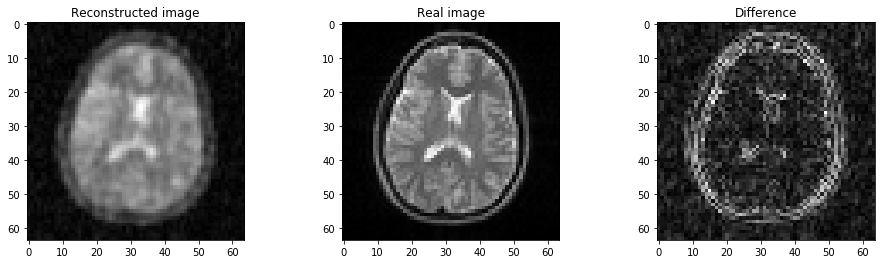

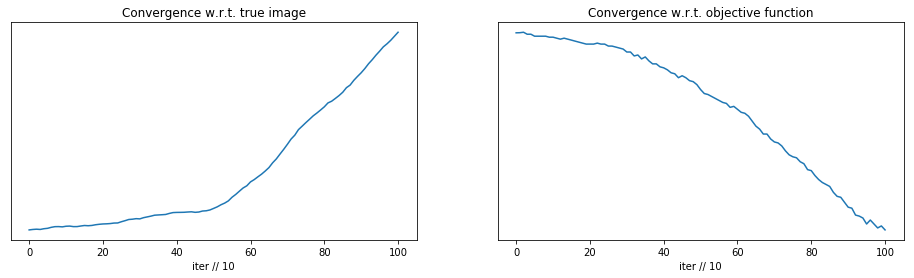

In [24]:
params['niter'] = 100
params['Reg'] = reg
start = time.time()
fista = alg.FISTA(params)
end = time.time()
x_fista = fista.result
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title("Reconstructed image")
ap.imshowgray(np.abs(x_fista))
plt.subplot(1,3,2)
plt.title("Real image")
ap.imshowgray(np.abs(x))
plt.subplot(1,3,3)
plt.title("Difference")
ap.imshowgray(np.abs(x - x_fista))
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title("Convergence w.r.t. true image")
plt.xlabel("iter // 10")
plt.semilogy(fista.conv)
plt.subplot(1,2,2)
plt.title("Convergence w.r.t. objective function")
plt.xlabel("iter // 10")
plt.semilogy(fista.objective)
print("Iteration: ", fista.counter)
print("True Signal Error: ", fista.conv[-1])
print("Objective Function Error: ", fista.objective[-1])
print("Time: ", end-start)

In [25]:
## Regularizer for wavelet transformation
def reg2(q, lamb):
    shape = q.shape
    q = q.reshape(64,64) 
    q = ap.SoftThreshComplex(ap.dwt2(q), lamb)
    q = ap.idwt2(q)
    return q.reshape(shape)

Iteration:  100
True Signal Error:  11.0244962245
Objective Function Error:  0.0161456449355
Time:  0.5241940021514893


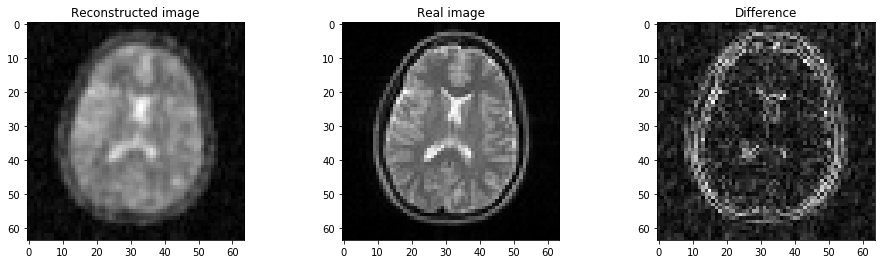

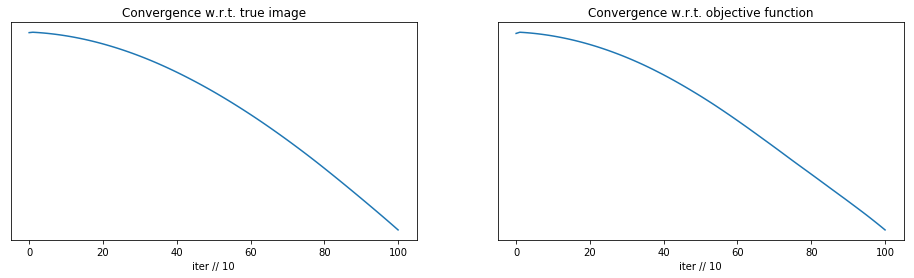

In [26]:
params['Reg'] = reg2
params['niter'] = 100
start = time.time()
fista = alg.FISTA(params)
end = time.time()
x_fista = fista.result
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title("Reconstructed image")
ap.imshowgray(np.abs(x_fista))
plt.subplot(1,3,2)
plt.title("Real image")
ap.imshowgray(np.abs(x))
plt.subplot(1,3,3)
plt.title("Difference")
ap.imshowgray(np.abs(x - x_fista))
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title("Convergence w.r.t. true image")
plt.xlabel("iter // 10")
plt.semilogy(fista.conv)
plt.subplot(1,2,2)
plt.title("Convergence w.r.t. objective function")
plt.xlabel("iter // 10")
plt.semilogy(fista.objective)
print("Iteration: ", fista.counter)
print("True Signal Error: ", fista.conv[-1])
print("Objective Function Error: ", fista.objective[-1])
print("Time: ", end-start)

## Regularizer Test

In [ ]:
for i in range(50):
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.title('std = ' + str( 1 / ((i * 2) + (i==0))) )
    ap.imshowgray(np.angle(array1[i]))
    plt.subplot(1,2,2)
    plt.title("magnitude")
    ap.imshowgray(np.abs(array1[i]))

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
ap.imshowgray(np.abs(bm3dtest1))
plt.title('Real and Imaginary  Seperation')
plt.subplot(1,4,2)
ap.imshowgray(np.abs(bm3dtest2))
plt.title('only Real')
plt.subplot(1,4,3)
ap.imshowgray(np.abs(bm3dtest3))
plt.title('Absolute value')
plt.subplot(1,4,4)
ap.imshowgray(np.abs(bm3dtest4))
plt.title('Mag and Phase  Seperation')

In [ ]:
print("reg1, imag and real, error: ", np.linalg.norm(bm3dtest1 - im))
print("reg2, only real, error: ", np.linalg.norm(bm3dtest2 - im))
print("reg3, absolute, error: ", np.linalg.norm(bm3dtest3 - im))
print("reg4, mag and phase, error: ", np.linalg.norm(bm3dtest4 - im))

In [ ]:
print("reg1, imag and real, TESTER error: ", np.linalg.norm(bm3dtest1 - TESTER))
print("reg2, only real, TESTER error: ", np.linalg.norm(bm3dtest2 - TESTER))
print("reg3, absolute, TESTER error: ", np.linalg.norm(bm3dtest3 - TESTER))
print("reg4, mag and phase, TESTER error: ", np.linalg.norm(bm3dtest4 - TESTER)) ## WEIRD

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
ap.imshowgray(np.abs(bm3dtest1 - im),0,0.9)
plt.title("Difference - reg1 (real & imag)")
plt.subplot(1,4,2)
ap.imshowgray(np.abs(bm3dtest2 - im))
plt.title("Difference - reg2 (real)")
plt.subplot(1,4,3)
ap.imshowgray(np.abs(bm3dtest3 - im))
plt.title("Difference - reg1 (abs)")
plt.subplot(1,4,4)
ap.imshowgray(np.abs(bm3dtest4 - im),0,0.9)
plt.title("Difference - reg2 (mag & phase)")
